In [2]:
import os
import sys
from pathlib import Path
from pickletools import OpcodeInfo
import numpy as np
import torch
import torch.nn as nn
import einops
import yaml
from omegaconf import DictConfig, OmegaConf
from coral.utils.data.dynamics_dataset import (KEY_TO_INDEX, TemporalDatasetWithCode)
from coral.utils.models.load_inr import create_inr_instance, load_inr_model
from coral.utils.data.load_data import get_dynamics_data, set_seed
from coral.utils.data.load_modulations import load_dynamics_modulations
from coral.utils.models.get_inr_reconstructions import get_reconstructions
from coral.utils.models.scheduling import ode_scheduling
from dino.ode_model import Decoder, Derivative
from torchdiffeq import odeint
from template.eval_coral import batch_eval_loop
from eval_dino import *

absurd-snowball-4660 # 20%
olive-haze-4659 # 5%
proud-waterfall-4693 # 100%

In [34]:
cfg = DictConfig(yaml.safe_load(open("config.yaml")))
dataset_name = cfg.data.dataset_name

run_name = cfg.inr.run_name
run_name = 'absurd-snowball-4660'
root_dir = Path(os.getenv("WANDB_DIR")) / dataset_name

In [35]:
# Load dyn_model 

tmp = torch.load(root_dir / "dino" / "model" / f"{run_name}.pt")
#cfg = tmp['cfg']
dec_state = tmp['dec_state_dict']
dyn_state = tmp['dyn_state_dict']

data_dir = cfg.data.dir
ntrain = cfg.data.ntrain
ntest = cfg.data.ntest
sub_tr = cfg.data.sub_tr
sub_te = cfg.data.sub_te
seed = cfg.data.seed
same_grid = cfg.data.same_grid
seq_inter_len = cfg.data.seq_inter_len
seq_extra_len = cfg.data.seq_extra_len

# optim
batch_size = cfg.optim.minibatch_size
lr = cfg.optim.lr

# inr
state_dim = cfg.inr.state_dim
code_dim = cfg.inr.code_dim
hidden_c_enc = cfg.inr.hidden_c_enc
n_layers = cfg.inr.n_layers
coord_dim = cfg.inr.coord_dim

# forecaster
hidden_c = cfg.forecaster.hidden_c

# Decoder
net_dec_params = {
    "state_c": state_dim,
    "code_c": code_dim,
    "hidden_c": hidden_c_enc,
    "n_layers": n_layers,
    "coord_dim": coord_dim,
}
# Forecaster
net_dyn_params = {
    "state_c": state_dim,
    "hidden_c": hidden_c,
    "code_c": code_dim,
}

In [36]:
batch_size = 1

In [37]:
print("sub_tr, sub_te : ", sub_tr, sub_te)

sub_tr, sub_te :  0.05 0.05


In [38]:
method = "rk4"

if dataset_name == "shallow-water-dino":
    n_steps = 500
else:
    n_steps = 300

net_dec = Decoder(**net_dec_params)
net_dec_dict = net_dec.state_dict()
pretrained_dict = {
    k: v for k, v in dec_state.items() if k in net_dec_dict
}
net_dec_dict.update(pretrained_dict)
net_dec.load_state_dict(pretrained_dict)
print(dict(net_dec.named_parameters()).keys())

net_dyn = Derivative(**net_dyn_params)
net_dyn_dict = net_dyn.state_dict()
pretrained_dict = {
    k: v for k, v in dyn_state.items() if k in net_dyn_dict
}
net_dyn_dict.update(pretrained_dict)
net_dyn.load_state_dict(net_dyn_dict)
print(dict(net_dyn.named_parameters()).keys())

states_params = tmp["states_params"]
net_dec = net_dec.to('cuda')
net_dyn = net_dyn.to('cuda')

dict_keys(['net.bilinear.0.A', 'net.bilinear.0.B', 'net.bilinear.0.bias', 'net.bilinear.1.A', 'net.bilinear.1.B', 'net.bilinear.1.bias', 'net.bilinear.2.A', 'net.bilinear.2.B', 'net.bilinear.2.bias', 'net.bilinear.3.A', 'net.bilinear.3.B', 'net.bilinear.3.bias', 'net.bilinear.4.A', 'net.bilinear.4.B', 'net.bilinear.4.bias', 'net.bilinear.5.A', 'net.bilinear.5.B', 'net.bilinear.5.bias', 'net.bilinear.6.A', 'net.bilinear.6.B', 'net.bilinear.6.bias', 'net.output_bilinear.weight', 'net.output_bilinear.bias', 'net.filters.0.weight', 'net.filters.1.weight', 'net.filters.2.weight', 'net.filters.3.weight', 'net.filters.4.weight', 'net.filters.5.weight', 'net.filters.6.weight'])
dict_keys(['net.net.0.weight', 'net.net.0.bias', 'net.net.1.beta', 'net.net.2.weight', 'net.net.2.bias', 'net.net.3.beta', 'net.net.4.weight', 'net.net.4.bias', 'net.net.5.beta', 'net.net.6.weight', 'net.net.6.bias'])


In [39]:
set_seed(seed)
random = 2
sub_tes = [4, 2, 1]
truths = []
preds = []

for sub_te in sub_tes:
    (u_train, u_eval_extrapolation, u_test, grid_tr, grid_tr_extra, grid_te) = get_dynamics_data(
        data_dir,
        dataset_name,
        ntrain,
        ntest,
        seq_inter_len=seq_inter_len,
        seq_extra_len=seq_extra_len,
        sub_tr=sub_tr,
        sub_te=sub_te,
        same_grid=same_grid,
    )

    u_train = einops.rearrange(u_train, 'N ... T -> N T ...')
    u_eval_extrapolation = einops.rearrange(u_eval_extrapolation, 'N ... T -> N T ...')
    u_test = einops.rearrange(u_test, 'N ... T -> N T ...')
    grid_tr = einops.rearrange(grid_tr, 'N ... T -> N T ...')
    grid_tr_extra = einops.rearrange(grid_tr_extra, 'N ... T -> N T ...')
    grid_te = einops.rearrange(grid_te, 'N ... T -> N T ...')

    testset = TemporalDatasetWithCode(
        u_test, grid_te, code_dim, dataset_name, None
    )

    test_loader = torch.utils.data.DataLoader(
        testset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
    )

    n_seq_train = u_train.shape[0]
    n_seq_test = u_test.shape[0]
    T_train = u_train.shape[1]
    T_test = u_test.shape[1]
    dt = 1

    timestamps_train = torch.arange(0, T_train, dt).float().cuda()
    timestamps_test = torch.arange(0, T_test, dt).float().cuda()

    print(f"data: {dataset_name}, u_train: {u_train.shape}, u_train_eval: {u_eval_extrapolation.shape}, u_test: {u_test.shape}")
    print(f"grid: grid_tr: {grid_tr.shape}, grid_tr_extra: {grid_tr_extra.shape}, grid_te: {grid_te.shape}")


    ground_truth = test_loader.dataset[random - 1: random][0]
    modulations = test_loader.dataset[random - 1: random][1]
    model_input = test_loader.dataset[random - 1: random][2]
    index = test_loader.dataset[2][-1]

    model_input = model_input.unsqueeze(-2)
    model_input = einops.repeat(model_input, '... c s -> ... (c k) s', k = 2).to('cuda')
    b_size, t_size = ground_truth.shape[0], ground_truth.shape[1]

    with torch.no_grad():
        states_params_index = states_params[index]
        #states_params_index = torch.stack(states_params_index, dim=1)
        codes = odeint(
            net_dyn, states_params_index[0], timestamps_test, method=method
        )  # t x batch x dim

        codes = codes.unsqueeze(0).permute(1, 0, 2).view(
            b_size, t_size, state_dim, code_dim
        )  # batch x t x dim

        model_output, _ = net_dec(model_input, codes)

        preds.append(model_output.detach().cpu())
        truths.append(ground_truth.detach().cpu())

data: shallow-water-dino, u_train: torch.Size([64, 20, 1638, 2]), u_train_eval: torch.Size([64, 40, 1638, 2]), u_test: torch.Size([8, 40, 32, 64, 2])
grid: grid_tr: torch.Size([64, 20, 1638, 3]), grid_tr_extra: torch.Size([64, 40, 1638, 3]), grid_te: torch.Size([8, 40, 32, 64, 3])
data: shallow-water-dino, u_train: torch.Size([64, 20, 1638, 2]), u_train_eval: torch.Size([64, 40, 1638, 2]), u_test: torch.Size([8, 40, 64, 128, 2])
grid: grid_tr: torch.Size([64, 20, 1638, 3]), grid_tr_extra: torch.Size([64, 40, 1638, 3]), grid_te: torch.Size([8, 40, 64, 128, 3])
data: shallow-water-dino, u_train: torch.Size([64, 20, 1638, 2]), u_train_eval: torch.Size([64, 40, 1638, 2]), u_test: torch.Size([8, 40, 128, 256, 2])
grid: grid_tr: torch.Size([64, 20, 1638, 3]), grid_tr_extra: torch.Size([64, 40, 1638, 3]), grid_te: torch.Size([8, 40, 128, 256, 3])


In [40]:
def rearrange(input):
    input = einops.rearrange(input, 'B T X Y C -> B X Y C T')
    return input

truths = [rearrange(truth) for truth in truths]
preds = [rearrange(pred) for pred in preds]

In [41]:
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
import numpy as np

def gif_baselines(plot_dir, title, preds, truths, channel, view=(100., 0.)):
    
    T = preds[0].shape[-1]
    ims = []
    proj = ccrs.Orthographic(*view)

    # add subfigure per subplot
    fig = plt.figure(constrained_layout=True)
    subfigs = fig.subfigures(nrows=3, ncols=1)

    # clear subplots

    latitude1 = torch.linspace(90.0, -90.0, truths[0].shape[1])
    longitude1 = torch.linspace(0.0, 360.0 - (360.0 / truths[0].shape[2]), truths[0].shape[2])
    longitude_grid1, latitude_grid1 = torch.meshgrid(longitude1, latitude1, indexing="xy")

    latitude2 = torch.linspace(90.0, -90.0, truths[1].shape[1])
    longitude2 = torch.linspace(0.0, 360.0 - (360.0 / truths[1].shape[2]), truths[1].shape[2])
    longitude_grid2, latitude_grid2 = torch.meshgrid(longitude2, latitude2, indexing="xy")

    latitude3 = torch.linspace(90.0, -90.0, truths[2].shape[1])
    longitude3 = torch.linspace(0.0, 360.0 - (360.0 / truths[2].shape[2]), truths[2].shape[2])
    longitude_grid3, latitude_grid3 = torch.meshgrid(longitude3, latitude3, indexing="xy")
    
    axes = subfigs[0].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[0].suptitle('Sub_te = 4')
    axs = subfigs[1].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[1].suptitle('Sub_te = 2')
    ax = subfigs[2].subplots(1, 2, subplot_kw={'projection': proj})
    subfigs[2].suptitle('Sub_te = 1')

    for i in range(T):
        im0 = axes[0].pcolormesh(longitude_grid1, latitude_grid1, truths[0][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        axes[0].set_title('Ground truth')        
        axes[0].gridlines(linewidth=1, color='black', alpha=0.05)

        im1 = axes[1].pcolormesh(longitude_grid1, latitude_grid1, preds[0][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        axes[1].gridlines(linewidth=1, color='black', alpha=0.05)
        axes[1].set_title('Reconstruction')
    

        im2 = axs[0].pcolormesh(longitude_grid2, latitude_grid2, truths[1][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        axs[0].set_title('Ground truth')        
        axs[0].gridlines(linewidth=1, color='black', alpha=0.05)

        im3 = axs[1].pcolormesh(longitude_grid2, latitude_grid2, preds[1][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        axs[1].gridlines(linewidth=1, color='black', alpha=0.05)
        axs[1].set_title('Reconstruction') 

        im4 = ax[0].pcolormesh(longitude_grid3, latitude_grid3, truths[2][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        ax[0].set_title('Ground truth')        
        ax[0].gridlines(linewidth=1, color='black', alpha=0.05)

        im5 = ax[1].pcolormesh(longitude_grid3, latitude_grid3, preds[2][0, ..., channel, i],
                                    transform=ccrs.PlateCarree(), cmap='plasma', shading = 'auto')
        ax[1].gridlines(linewidth=1, color='black', alpha=0.05)
        ax[1].set_title('Reconstruction') 

        ims.append([im0, im1, im2, im3, im4, im5])

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)

    ani.save(os.path.join(plot_dir, title),
            dpi=300)  # , writer=PillowWriter(fps=25))

MovieWriter ffmpeg unavailable; using Pillow instead.


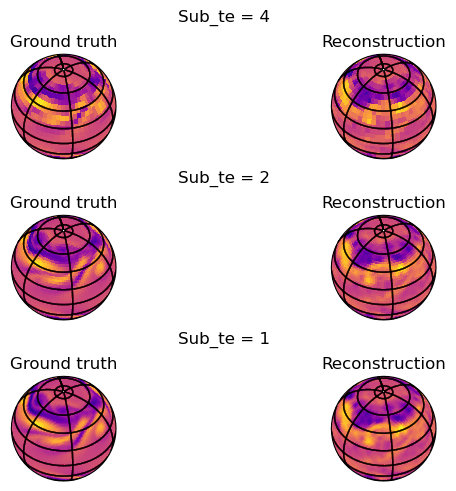

In [42]:
gif_baselines('/home/kassai/code/coral/visualizations/', 'predictions_dino_20%.gif', preds, truths, channel = 1, view = (-10, 45))